---
<div style="background-color:white; text-align:center; padding:20px;">
    <h2 style="color:black; font-family: Verdana, sans-serif;"><strong>U-net Model</strong></h2>
    <p style="font-size: 14px; color: black; font-family: Verdana, sans-serif;"> 
        <table style="margin: auto; border-collapse: collapse;">
            <tr>
                <th style="border: 0;">Teamleden</th>
                <th style="border: 0;">GitHub Username</th>
            </tr>
            <tr>
                <td style="border: 0;">Vince Ammerlaan</td>
                <td style="border: 0;">Vince16270</td>
            </tr>
            <tr>
                <td style="border: 0;">Tommi Lander</td>
                <td style="border: 0;">tommi7</td>
            </tr>
            <tr>
                <td style="border: 0;">Nima Ghafar</td>
                <td style="border: 0;">NimaGhafar</td>
            </tr>
        </table>
    </p>
</div>

<div style="display: flex; justify-content: center; align-items: center; margin-top:20px;">
    <img src="https://fishpassapp.co.uk/img/biosecurity/giant-hogweed-v2.png" alt="genres" style="max-width: 100%; max-height: 100%;">
</div>

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [30]:
def preprocess_mask(mask):
    mask = mask / 255.0
    return mask

def display_images(display_list, title_list):
    plt.figure(figsize=(15, 15))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title_list[i])
        # Ensure the array has 3 dimensions
        if len(display_list[i].shape) == 2:
            display_image = tf.expand_dims(display_list[i], axis=-1)  # Add channel dimension
        else:
            display_image = display_list[i]
        plt.imshow(tf.keras.utils.array_to_img(display_image))
        plt.axis('off')
    plt.show()

def augment_image(image, mask):
    image_data_gen = ImageDataGenerator(rotation_range=20,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        shear_range=0.1,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest')
    mask_data_gen = ImageDataGenerator(rotation_range=20,
                                       width_shift_range=0.1,
                                       height_shift_range=0.1,
                                       shear_range=0.1,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    seed = np.random.randint(0, 10000)
    aug_image = image_data_gen.random_transform(image, seed=seed)
    aug_mask = mask_data_gen.random_transform(mask, seed=seed)

    return aug_image, aug_mask

def parse_image(img_path, mask_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    img = img / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, [256, 256])
    mask = preprocess_mask(mask)

    if tf.random.uniform(()) > 0.5:
        img, mask = tf.numpy_function(augment_image, [img, mask], [tf.float32, tf.float32])

    return img, mask

def tfdata_generator(image_files, mask_files, batch_size, seed=42):
    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
    dataset = dataset.shuffle(buffer_size=len(image_files), seed=seed)
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat()  # Repeat the dataset indefinitely
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

def iou(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [32]:
# Load image and mask file paths
image_dir = 'self-labeled data/image_patches'
mask_dir = 'self-labeled data/mask_patches'
batch_size = 64

image_files = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith('.jpg')]
mask_files = [os.path.join(mask_dir, msk) for msk in os.listdir(mask_dir) if msk.endswith('.jpg')]

# Split de data in training en test sets
train_images, test_images, train_masks, test_masks = train_test_split(image_files, mask_files, test_size=0.2, random_state=42)

train_dataset = tfdata_generator(train_images, train_masks, batch_size)
test_dataset = tfdata_generator(test_images, test_masks, batch_size)

steps_per_epoch = len(train_images) // batch_size
validation_steps = len(test_images) // batch_size

In [5]:
def unet_model(input_size=(256, 256, 3)):
    inputs = tf.keras.layers.Input(input_size)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    u6 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_model()

In [6]:
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule),
              loss='binary_crossentropy',
              metrics=[iou])

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min', save_best_only=True)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [7]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(train_dataset, steps_per_epoch=steps_per_epoch, epochs=1, validation_data=test_dataset, validation_steps=validation_steps, callbacks=[model_checkpoint_callback, early_stopping])

2024-05-25 13:48:12.766777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


110/110 [==============================] - ETA: 0s - loss: 0.2368 - iou: 0.0308

2024-05-25 14:03:36.367766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


110/110 [==============================] - 965s 9s/step - loss: 0.2368 - iou: 0.0308 - val_loss: 0.1395 - val_iou: 0.0415


1/1 [==============================] - 0s 11ms/step
[[[[0.26663345]
   [0.13778895]
   [0.12040109]
   ...
   [0.17813404]
   [0.2320796 ]
   [0.28628626]]

  [[0.19260235]
   [0.06868479]
   [0.04844118]
   ...
   [0.09029176]
   [0.12861027]
   [0.17902923]]

  [[0.11586836]
   [0.04084937]
   [0.0240634 ]
   ...
   [0.06131626]
   [0.10190023]
   [0.14232723]]

  ...

  [[0.17988166]
   [0.07186017]
   [0.04857321]
   ...
   [0.01906973]
   [0.02879433]
   [0.06138626]]

  [[0.19933137]
   [0.10878475]
   [0.05604139]
   ...
   [0.04001412]
   [0.04779207]
   [0.1075452 ]]

  [[0.29939756]
   [0.21185575]
   [0.13952918]
   ...
   [0.11386629]
   [0.12939574]
   [0.23721378]]]]


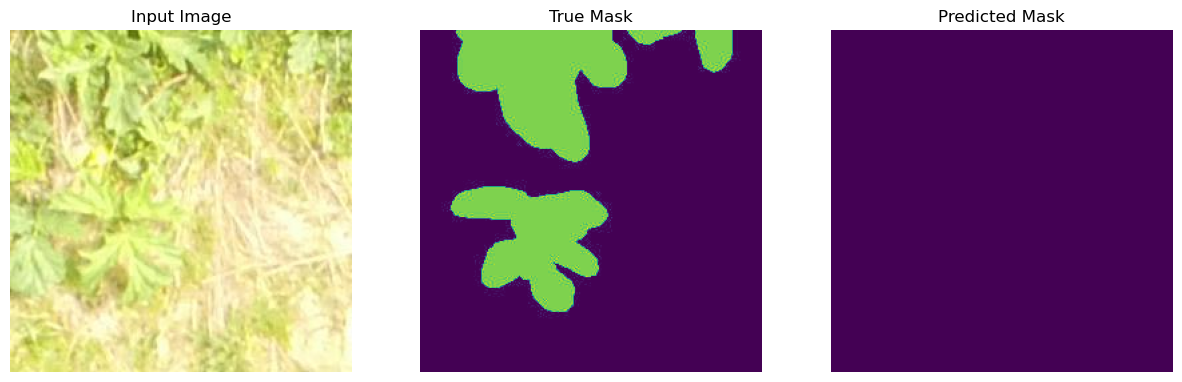

In [26]:
test_image_batch, test_mask_batch = next(iter(test_dataset))
test_image = test_image_batch[0:1]
test_mask = test_mask_batch[0:1]

pred_mask = (pred_mask > 0.5).astype(np.uint8)

display_list = [test_image[0], test_mask[0], pred_mask.squeeze()]
title_list = ['Input Image', 'True Mask', 'Predicted Mask']
display_images(display_list, title_list)

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 7: Bronnenlijst </strong></h2>
</div>

- _GeeksforGeeks. (2022, 1 augustus). Image segmentation using TensorFlow. GeeksforGeeks._ https://www.geeksforgeeks.org/image-segmentation-using-tensorflow/